In [14]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

## EPA vs. Actual Points After 4th-Down Decisions

This notebook analyzes what happens **after teams go for it on 4th down**, comparing:

- **EPA from the 4th-down decision / play**
- vs. **the actual points scored afterward**

For each 4th-down attempt, we track the resulting points based on the outcome:

- **If the team converts** → points scored on the **rest of their drive**
- **If the team fails** → points scored on the **opponent’s next drive**

The goal is to see how often real outcomes match, exceed, or fall short of model expectations.


In [15]:
df = nfl.import_pbp_data(years = [2025])


2025 done.
Downcasting floats.


In [16]:
# df = nfl.import_pbp_data(years = [2025])

# Plays that went for it
df['goforit'] = 0

df.loc[
    (df['down'] == 4) & (df['play_type'].isin(['run', 'pass'])),
    'goforit'
] = 1

# Conversion? 
df['convert_4th'] = np.where(df['fourth_down_converted'] == 1, 1, 0)

# Create unique ID based on game_id, drive, and posteam
df['cum_drive_id'] = df.groupby(['game_id','drive','posteam']).ngroup()



# If they convert, get the rest of that drive's outcome
# unique game, drive, and team with possesion
wentforit_convert_drive = df.groupby(['game_id','drive','posteam'])

/tmp/ipykernel_85408/2093892342.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['goforit'] = 0
/tmp/ipykernel_85408/2093892342.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['convert_4th'] = np.where(df['fourth_down_converted'] == 1, 1, 0)


In [44]:
def get_drive_points_scores(df, game_id, drive, next_drive=False):
    ''' This function will take in the dataframe, drive id and 
    return the points scored for either the current drive or the opponents next drive
    
    return -> INT: number of points scored on next drive (positive if wentforit team scores, negative if no convert and other team scores)
    '''
    if next_drive:
        drive = drive + 1

    drive_df = df[(df.game_id == game_id) & (df.drive == drive)]

    if drive_df.empty:
        return 0

    points = (
        drive_df.posteam_score_post.max()
        - drive_df.posteam_score_post.min()
    )

    # opponent score should be negative
    return -points if next_drive else points

In [67]:
# Get a dataframe with the posteam, defteam ,yardline_100, convert4th, EPA for 4th down play, points next drive

wentforit = df.loc[(df.goforit == 1)][['cum_drive_id','game_id','drive','posteam','defteam','yardline_100','convert_4th','epa','ep']]
wentforit['actual_pa'] = wentforit.apply(
    lambda x: get_drive_points_scores(
        df,
        x.game_id,
        x.drive,
        next_drive = (x.convert_4th == 0)
    ),
    axis=1
)


In [48]:
wentforit.head()

,cum_drive_id,game_id,drive,posteam,defteam,yardline_100,convert_4th,epa,actual_pa
176,18.0,2025_01_ARI_NO,19.0,NO,ARI,24.0,1,0.613980,0.0
180,18.0,2025_01_ARI_NO,19.0,NO,ARI,18.0,0,-2.525238,0.0
341,37.0,2025_01_BAL_BUF,19.0,BUF,BAL,10.0,1,3.997448,7.0
378,42.0,2025_01_CAR_JAX,1.0,JAX,CAR,63.0,1,2.358610,3.0
471,52.0,2025_01_CAR_JAX,11.0,CAR,JAX,5.0,0,-3.970827,-0.0


In [68]:
res = wentforit.groupby('posteam').agg({'epa':'sum','actual_pa':'sum','ep':'sum'}).reset_index()

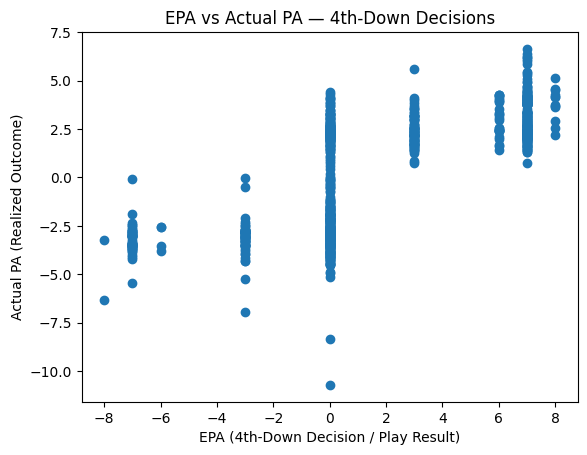

In [71]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(
    wentforit["actual_pa"],   # realized actual PA
    wentforit["epa"]        # EPA of 4th-down play / decision
)

plt.xlabel("EPA (4th-Down Decision / Play Result)")
plt.ylabel("Actual PA (Realized Outcome)")
plt.title("EPA vs Actual PA — 4th-Down Decisions")

plt.show()


In [69]:
res.sort_values('epa',ascending=False)

,posteam,epa,actual_pa,ep
15,KC,46.963089,82.0,49.296959
4,CAR,42.350197,106.0,42.440334
16,LA,30.534973,86.0,53.482143
21,NE,26.625313,51.0,25.665676
8,DAL,21.246765,81.0,49.565742
25,PHI,18.966064,63.0,28.983345
10,DET,17.612251,70.0,52.622063
3,BUF,17.089434,68.0,34.205078
6,CIN,16.557777,32.0,22.978252
13,IND,13.113535,62.0,43.005032


## Rethinking EPA for This Question

While EPA is useful, it may not be the best metric for this comparison.

- **EPA measures the impact of a single play** on expected points
- But our outcome measure is **total points scored after the decision**
- Naturally, the realized points from an entire drive will often be much larger than the single-play EPA value

Instead, **Expected Points (EP)** at the moment of the 4th-down decision provides a more intuitive baseline:

- EP represents what teams *typically* score from that situation
- Actual Points represent what they *actually* scored afterward

So comparing **EP → Actual Points** tells a clearer story about
how outcomes aligned with — or diverged from — expectation.


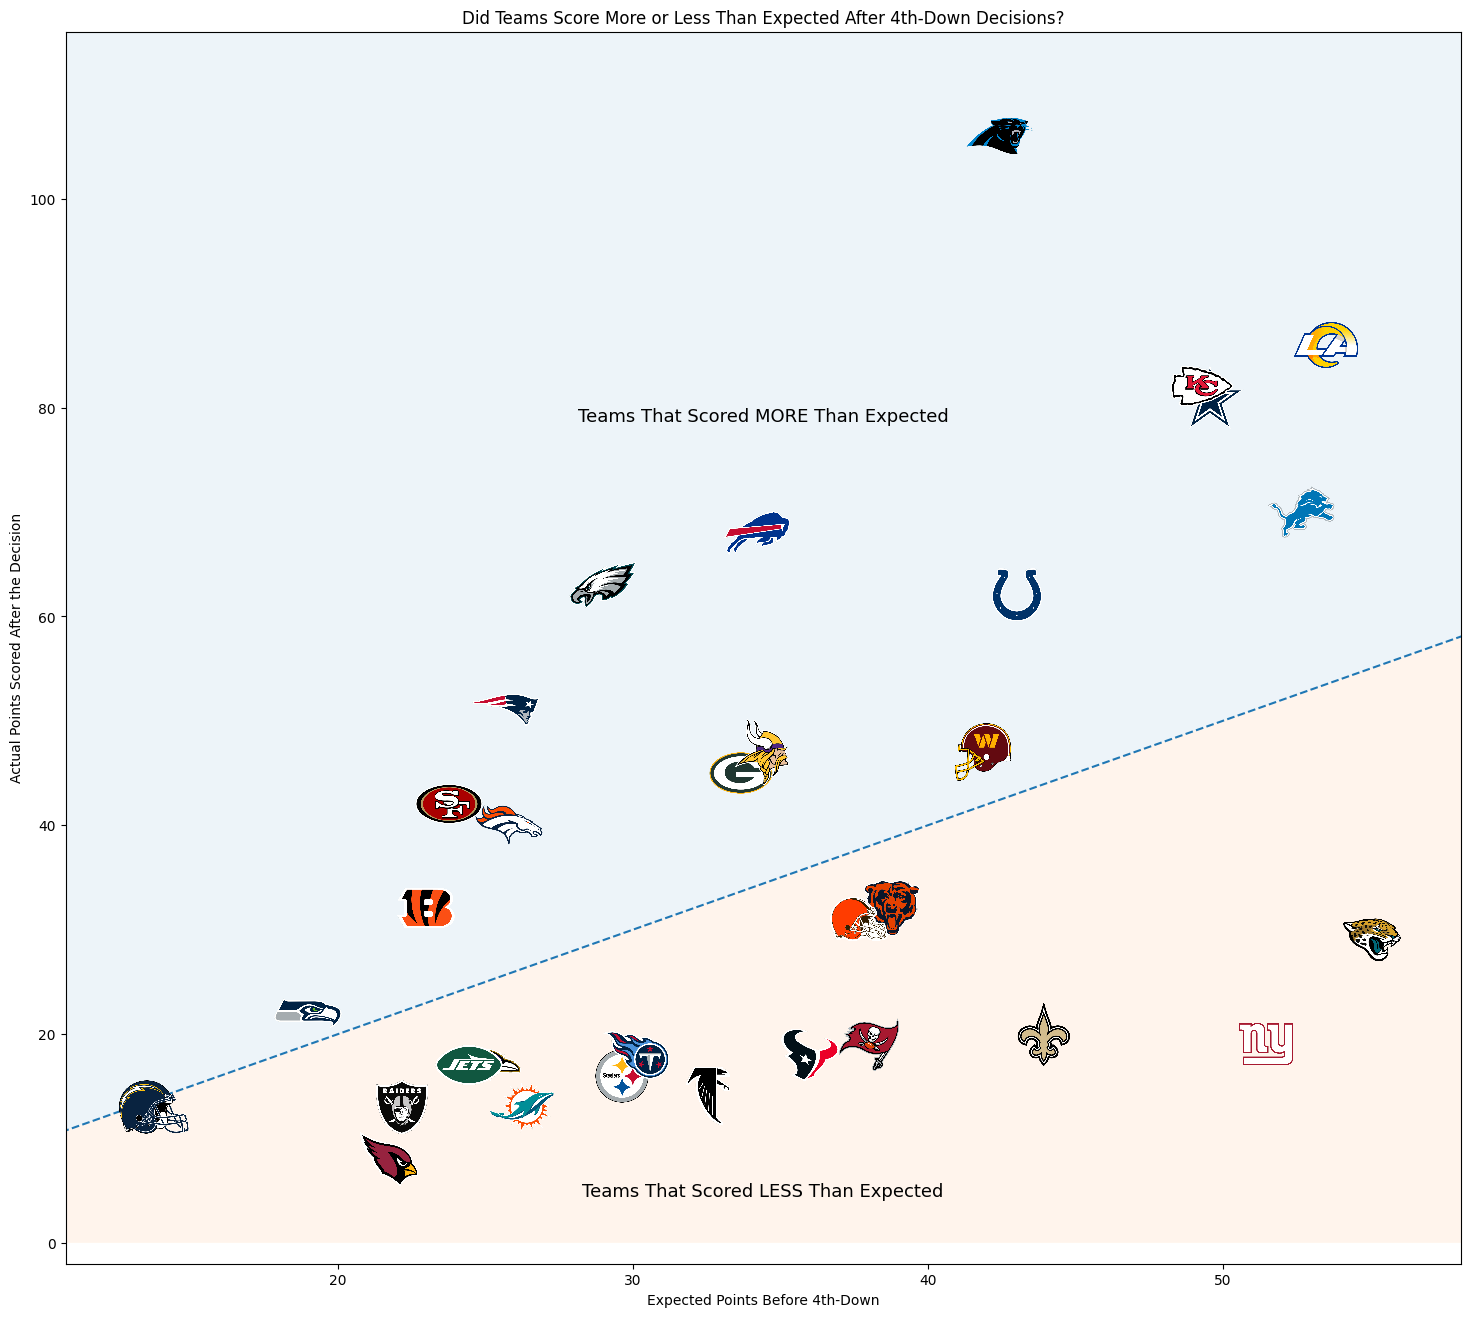

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(18, 16))

ax.set_title("Did Teams Score More or Less Than Expected After 4th-Down Decisions?")
ax.set_xlabel("Expected Points Before 4th-Down")
ax.set_ylabel("Actual Points Scored After the Decision")

def get_logo(team):
    path = f"logos/{team}.png"
    return plt.imread(path)

# highlight = {"CAR", "KC", "JAX", "LAC"}

x = res["ep"].values
y = res["actual_pa"].values

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

ax.set_xlim(xmin - 3, xmax + 3)
ax.set_ylim(ymin - 10, ymax + 10)

# --- Diagonal expectation line (y = x) ---
line_min = min(xmin, ymin)
line_max = max(xmax, ymax)

ax.plot([line_min, line_max], [line_min, line_max],
        linestyle="--")

# ax.text(
#     line_max, line_max,
#     "Equal to Expectation (y = x)",
#     ha="right", va="bottom", alpha=0.8
# )

# --- Shaded regions ---
ax.fill_between(
    [line_min, line_max],
    [line_min, line_max],
    120, #ymax
    alpha=0.08
)

ax.fill_between(
    [line_min, line_max],
    0, #ymin
    [line_min, line_max],
    alpha=0.08
)

# --- Light background logos for all teams ---
for _, row in res.iterrows():
    logo = OffsetImage(get_logo(row["posteam"]), zoom=0.1)#, alpha=0.35)
    ab = AnnotationBbox(logo, (row["ep"], row["actual_pa"]), frameon=False)
    ax.add_artist(ab)

# # --- Highlighted teams (larger + solid logos) ---
# for _, row in res.iterrows():
#     if row["posteam"] in highlight:
#         logo = OffsetImage(get_logo(row["posteam"]), zoom=0.11)
#         ab = AnnotationBbox(logo, (row["ep"], row["actual_pa"]), frameon=False)
#         ax.add_artist(ab)

#         ax.annotate(
#             row["posteam"],
#             (row["ep"], row["actual_pa"]),
#             textcoords="offset points",
#             xytext=(10, 10),
#             fontsize=12,
#             weight="bold"
#         )

# --- Region labels ---
ax.text(
    (xmin + xmax)/2,
    80,
    #ymax - (0.04*(ymax-ymin)),
    "Teams That Scored MORE Than Expected",
    ha="center", va="top", fontsize=13
)

ax.text(
    (xmin + xmax)/2,
    ymin + (0.04*(ymin-ymax)),
    "Teams That Scored LESS Than Expected",
    ha="center", va="bottom", fontsize=13
)

plt.show()


In [134]:
# Save to PNG (300 dpi, tight margins, white background)
fig.savefig(
    "ep_vs_actual_pa_4th_down.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()


## Controlling for Team Strength with Regression

Teams with stronger offenses are naturally more likely to score points after 4th-down decisions.  
To make a fair comparison, we want to understand:

> How much did teams score **relative to expectation**,  
> after accounting for their underlying offensive strength?

To do this, we run a regression where:

- the response variable is **Actual Points − Expected Points**
- and the predictors include **offensive rating (and other team factors)**

This allows us to isolate the portion of over- or under-performance that cannot be explained simply by having a better (or worse) offense.


In [116]:
name_to_abbr = {
    "Houston Texans": "HOU",
    "Seattle Seahawks": "SEA",
    "Denver Broncos": "DEN",
    "Philadelphia Eagles": "PHI",
    "Kansas City Chiefs": "KC",
    "Carolina Panthers": "CAR",
    "Los Angeles Chargers": "LAC",
    "Jacksonville Jaguars": "JAX",
    "Buffalo Bills": "BUF",
    "Dallas Cowboys": "DAL",
    "Detroit Lions": "DET",
    "Green Bay Packers": "GB",
    "Chicago Bears": "CHI",
    "Cleveland Browns": "CLE",
    "Cincinnati Bengals": "CIN",
    "Minnesota Vikings": "MIN",
    "New York Giants": "NYG",
    "New York Jets": "NYJ",
    "Los Angeles Rams": "LA",
    "Las Vegas Raiders": "LV",
    "New Orleans Saints": "NO",
    "New England Patriots": "NE",
    "Tampa Bay Buccaneers": "TB",
    "Atlanta Falcons": "ATL",
    "Washington Commanders": "WAS",
    "Tennessee Titans": "TEN",
    "San Francisco 49ers": "SF",
    "Miami Dolphins": "MIA",
    "Baltimore Ravens": "BAL",
    "Pittsburgh Steelers": "PIT",
    "Indianapolis Colts": "IND",
    "Arizona Cardinals": "ARI"
}


In [105]:
off = pd.read_csv("Offense_Rating_2025.csv")
deff = pd.read_csv("Defense_Rating_2025.csv")


In [112]:
teams_ = off.merge(deff,on = 'Tm',suffixes=["Off","Def"])

In [113]:
teams = teams_.copy()

# Clean column names a bit
teams_.columns = (
    teams.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("/", "_")
)


In [117]:
teams["team_abbr"] = teams["Tm"].map(name_to_abbr)

In [118]:
teams[teams["team_abbr"].isna()][["Tm"]]

,Tm


In [121]:
keep = ['team_abbr','Pts/GOff','Pts/GDef']

In [122]:
res = res.merge(
    teams[keep],
    left_on="posteam",
    right_on="team_abbr",
    how="left"
)


In [127]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

res["pa_minus_ep"] = res["actual_pa"] - res["ep"]


features = ["Pts/GOff", "Pts/GDef"]

# 3) standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(res[features])

y = res["pa_minus_ep"]

# 4) regression fit
X_const = sm.add_constant(res[features])
model = sm.OLS(y, X_const).fit()

print(model.summary())

# 5) compute predicted & normalized residuals
res["expected_pa_minus_ep"] = model.predict(X_const)
res["normalized_residual"] = res["pa_minus_ep"] - res["expected_pa_minus_ep"]


                            OLS Regression Results                            
Dep. Variable:            pa_minus_ep   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     2.561
Date:                Sat, 27 Dec 2025   Prob (F-statistic):             0.0945
Time:                        11:09:19   Log-Likelihood:                -141.69
No. Observations:                  32   AIC:                             289.4
Df Residuals:                      29   BIC:                             293.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.3906     39.481     -0.466      0.6

## Checking Regression Model Assumptions

Before interpreting the regression results, we first verify that the model is statistically appropriate.

We examine:

- **Linearity** — the relationship between predictors and residuals should be roughly linear  
- **Normality of residuals** — residuals should be approximately normally distributed  
- **Homoscedasticity** — variance of residuals should be consistent across predictions  
- **Influential outliers** — no single team should dominate the model fit

If these assumptions reasonably hold, we can interpret the regression
results and residuals with greater confidence.


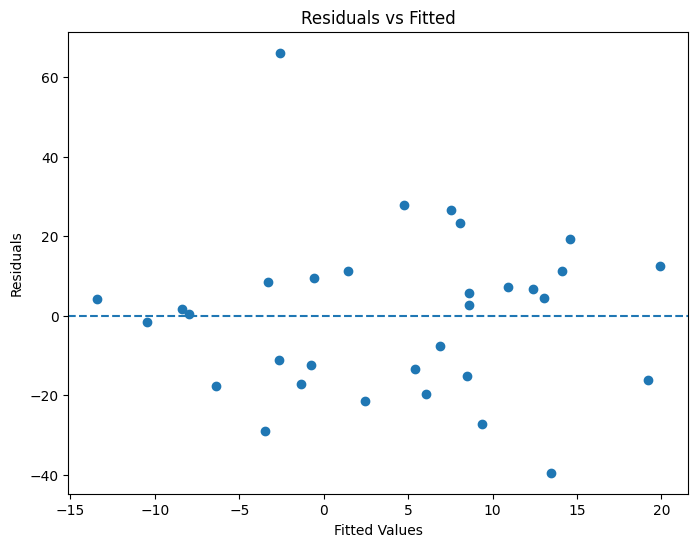

In [135]:
import matplotlib.pyplot as plt

fitted = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8,6))
plt.scatter(fitted, residuals)
plt.axhline(0, linestyle="--")

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")

plt.show()


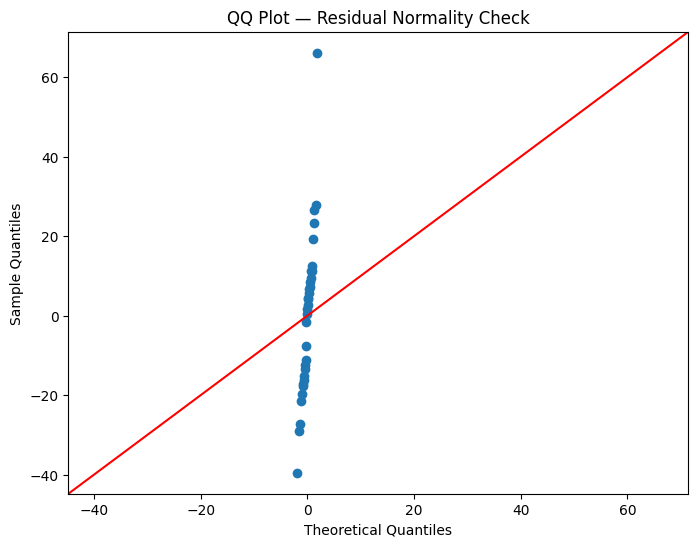

In [140]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(8,6))

sm.qqplot(residuals, line="45", ax=ax)

ax.set_title("QQ Plot — Residual Normality Check")

plt.show()


HMMMMMWell now we have to see why the tails are so off

In [141]:
res["std_resid"] = residuals / residuals.std()

res.sort_values("std_resid", key=abs, ascending=False)[
    ["posteam", "pa_minus_ep", "std_resid"]
].head(8)


,posteam,pa_minus_ep,std_resid
4,CAR,63.559666,3.213848
14,JAX,-26.061985,-1.919838
23,NYG,-32.455883,-1.407942
15,KC,32.703041,1.356417
12,HOU,-18.001446,-1.329987
25,PHI,34.016655,1.286603
8,DAL,31.434258,1.134819
29,TB,-18.982990,-1.040079


In [142]:
rmodel = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()
print(rmodel.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   32
Model:                            RLM   Df Residuals:                       29
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 27 Dec 2025                                         
Time:                        11:30:10                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.9766     39.360     -0.736      0.4

In [143]:
qmodel = sm.QuantReg(y, X_const).fit(q=0.5)
print(qmodel.summary())


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.1575
Model:                       QuantReg   Bandwidth:                       41.28
Method:                 Least Squares   Sparsity:                        71.89
Date:                Sat, 27 Dec 2025   No. Observations:                   32
Time:                        11:30:48   Df Residuals:                       29
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5725     66.678     -0.114      0.910    -143.944     128.799
Pts/GOff       2.5673      1.621      1.584      0.124      -0.748       5.882
Pts/GDef      -0.7143      1.943     -0.368      0.716      -4.689       3.260


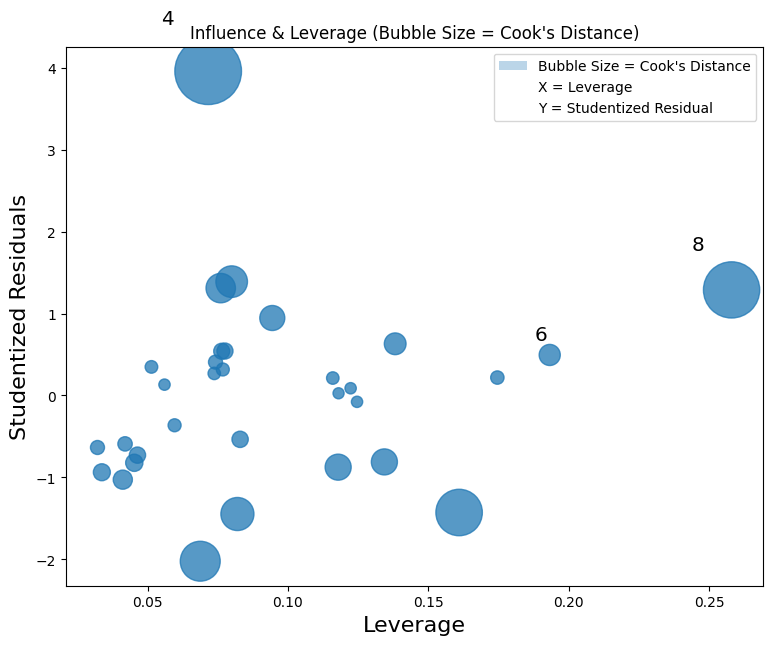

In [139]:
from statsmodels.graphics.regressionplots import influence_plot
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,7))

influence_plot(model, ax=ax)

ax.set_title("Influence & Leverage (Bubble Size = Cook's Distance)")

# --- Custom Legend Elements ---
bubble = mpatches.Patch(alpha=0.3, label="Bubble Size = Cook's Distance")
xax = mlines.Line2D([], [], color="none", label="X = Leverage")
yax = mlines.Line2D([], [], color="none", label="Y = Studentized Residual")

ax.legend(handles=[bubble, xax, yax], loc="upper right")

plt.show()


## Interpreting the Results — High Variance & Heavy Tails

The model shows clear evidence of **extreme outcomes in the tails**. A small number of drives have very large scoring swings, which exert a meaningful influence on the regression fit.

Even after applying:

- robust regression (down-weighting outliers), and
- quantile regression (focusing on median effects)

we still observe a **positive association between offensive strength and PA − EP**.

However:

- the relationship is **real but modest**
- the R² value remains low
- much of the variation is driven by high-impact, high-leverage drives

So we can (cautiously) conclude that **better offenses are more likely to outperform EP after 4th-down decisions**, but there are clearly **other unmodeled factors at work**.

---

### Next Steps

To better explain the remaining variance, we plan to:

- model outcomes **at the drive level**  
  using mixed-effects to account for:
  - team offensive rating, and
  - opponent defensive strength

- examine the **field position and context of the 4th-down attempt**

While EP already encodes situational value, recreating it using interactions between:

- field position  
- distance to go  
- opponent strength  

may reveal a richer structure — and potentially a more expressive model than the baseline EP framework.
